In [5]:
import cv2
import os
import numpy as np
import statistics
import re
import pandas as pd
import time
import matplotlib.pyplot as plt
from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')

# Definir rutas base
carpeta_base = "/content/drive/MyDrive/disco_diffusion"
categorias = ["art", "faces", "landscapes"]

# Inicializar variables para estadísticas
todas_distancias = []
todas_coincidencias = []
promedio_caracteristicas = []
resultados = []

tiempo_total_inicio = time.time()  # Iniciar cronómetro global

# Inicializar SIFT
sift = cv2.SIFT_create()
matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Función para calcular distancia euclidiana entre descriptores
def calcular_distancia(matches):
    distancias = [match.distance for match in matches]
    return np.mean(distancias) if distancias else 0

# Procesar cada categoría
for categoria in categorias:
    carpeta_eng = os.path.join(carpeta_base, categoria, "english")
    carpeta_esp = os.path.join(carpeta_base, categoria, "spanish")
    carpeta_guardado = os.path.join("/content", "PROCESADAS", categoria)
    os.makedirs(carpeta_guardado, exist_ok=True)

    imagenes_eng = {img: os.path.join(carpeta_eng, img) for img in os.listdir(carpeta_eng) if img.endswith(('.png', '.jpg', '.jpeg'))}
    imagenes_esp = {img: os.path.join(carpeta_esp, img) for img in os.listdir(carpeta_esp) if img.endswith(('.png', '.jpg', '.jpeg'))}

    for eng_img, eng_path in imagenes_eng.items():
        num = re.search(r'\d+', eng_img).group()  # Extraer número de la imagen
        esp_img = f"spanish_image_{num}.png"

        if esp_img in imagenes_esp:
            esp_path = imagenes_esp[esp_img]
            tiempo_inicio = time.time()  # Iniciar cronómetro por imagen

            # Leer imágenes en escala de grises
            img1 = cv2.imread(eng_path, cv2.IMREAD_GRAYSCALE)
            img2 = cv2.imread(esp_path, cv2.IMREAD_GRAYSCALE)

            # Extraer características SIFT
            kp1, des1 = sift.detectAndCompute(img1, None)
            kp2, des2 = sift.detectAndCompute(img2, None)

            # Hacer matching
            if des1 is not None and des2 is not None:
                matches = matcher.match(des1, des2)
                distancia_promedio = calcular_distancia(matches)
                cantidad_matches = len(matches)

                todas_distancias.append(distancia_promedio)
                todas_coincidencias.append(cantidad_matches)
                promedio_caracteristicas.append((len(kp1) + len(kp2)) / 2)

                # Guardar resultados en lista
                tiempo_fin = time.time()  # Fin de cronómetro por imagen
                tiempo_ejecucion = tiempo_fin - tiempo_inicio
                resultados.append([categoria, num, distancia_promedio, cantidad_matches, tiempo_ejecucion])

                # Dibujar coincidencias
                img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

                # Guardar imagen procesada
                nombre_guardado = os.path.join(carpeta_guardado, f"procesada_{num}.png")
                cv2.imwrite(nombre_guardado, img_matches)

                # Mostrar imagen procesada
                plt.figure(figsize=(10, 5))
                plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
                plt.title(f"Imagen {num} - {categoria}")
                plt.axis("off")
                plt.show()

                 (f"Imagen {num} - {categoria}:")
                print(f"  - Distancia promedio: {distancia_promedio:.2f}")
                print(f"  - Matches encontrados: {cantidad_matches}\n")



# Guardar resultados en CSV
df_resultados = pd.DataFrame(resultados, columns=["Categoria", "Numero", "Distancia Promedio", "Matches", "Tiempo de Ejecución (s)"])
df_resultados.to_csv("/content/resultados_sift.csv", index=False)

# Calcular estadísticas finales
if todas_distancias:
    tiempo_total_fin = time.time()  # Fin del cronómetro global
    tiempo_total_ejecucion = tiempo_total_fin - tiempo_total_inicio

    print("\nESTADÍSTICAS FINALES:")
    print(f"  - Distancia máxima: {max(todas_distancias):.2f}")
    print(f"  - Distancia mínima: {min(todas_distancias):.2f}")
    print(f"  - Distancia media: {statistics.mean(todas_distancias):.2f}")
    print(f"  - Desviación estándar de distancia: {statistics.stdev(todas_distancias):.2f}")
    print(f"  - Máximo matches: {max(todas_coincidencias)}")
    print(f"  - Mínimo matches: {min(todas_coincidencias)}")
    print(f"  - Promedio de matches: {statistics.mean(todas_coincidencias):.2f}")
    print(f"  - Desviación estándar de matches: {statistics.stdev(todas_coincidencias):.2f}")
    print(f"  - Promedio de características detectadas: {statistics.mean(promedio_caracteristicas):.2f}")
    print(f"  - Desviación estándar de características detectadas: {statistics.stdev(promedio_caracteristicas):.2f}")
    print(f"  - Tiempo total de ejecución: {tiempo_total_ejecucion:.2f} segundos")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

ESTADÍSTICAS FINALES:
  - Distancia máxima: 308.92
  - Distancia mínima: 228.40
  - Distancia media: 268.62
  - Desviación estándar de distancia: 12.37
  - Máximo matches: 1257
  - Mínimo matches: 142
  - Promedio de matches: 608.66
  - Desviación estándar de matches: 248.88
  - Promedio de características detectadas: 2525.44
  - Desviación estándar de características detectadas: 991.49
  - Tiempo total de ejecución: 264.00 segundos


<ipython-input-6-3df80fe60727>:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(distancias_por_categoria.values(), labels=distancias_por_categoria.keys(), patch_artist=True)


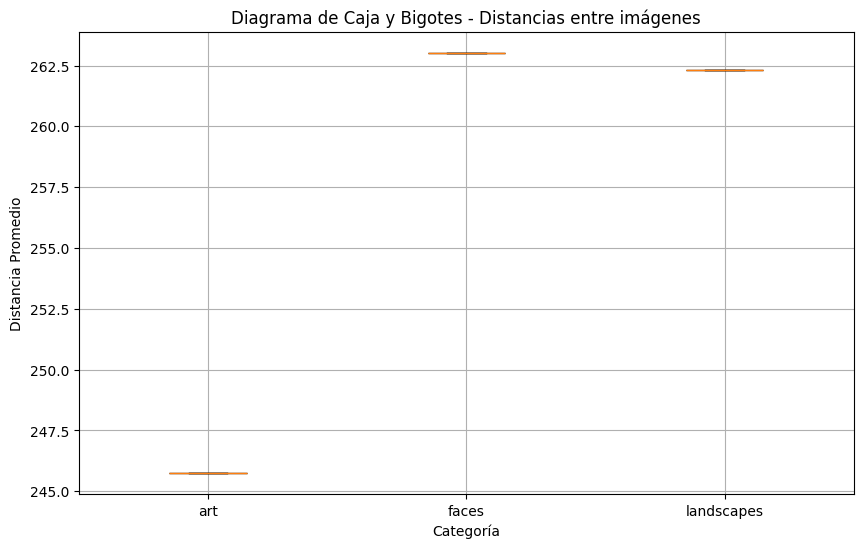

In [6]:
# Código para graficar diagrama de caja y bigotes
def graficar_boxplot():
    plt.figure(figsize=(10, 6))
    distancias_por_categoria = {categoria: [] for categoria in categorias}

    for categoria, distancia in zip(categorias, todas_distancias):
        distancias_por_categoria[categoria].append(distancia)

    box = plt.boxplot(distancias_por_categoria.values(), labels=distancias_por_categoria.keys(), patch_artist=True)
    colores = ['lightblue', 'lightgreen', 'lightcoral']
    for patch, color in zip(box['boxes'], colores):
        patch.set_facecolor(color)

    plt.xlabel("Categoría")
    plt.ylabel("Distancia Promedio")
    plt.title("Diagrama de Caja y Bigotes - Distancias entre imágenes")
    plt.grid(True)
    plt.show()

graficar_boxplot()


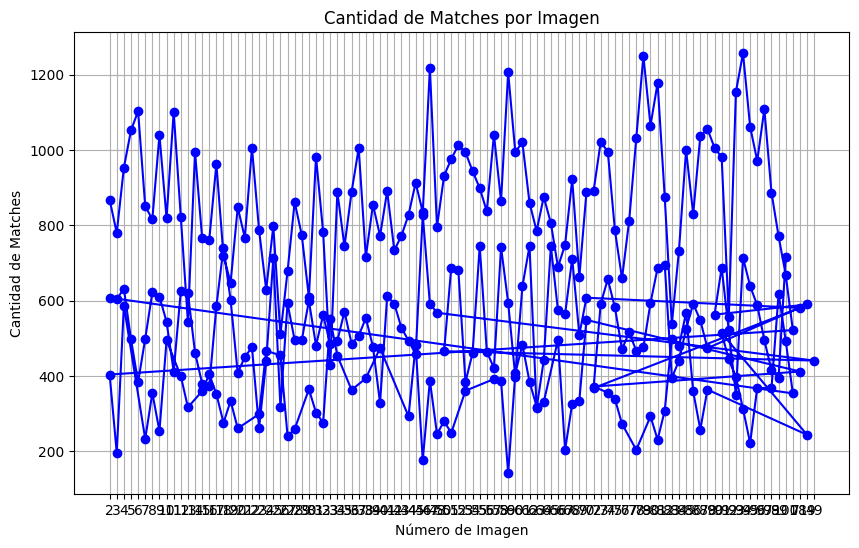

In [4]:
# Gráfica de cantidad de matches por imagen
def graficar_matches():
    plt.figure(figsize=(10, 6))

    imagenes = [res[1] for res in resultados]
    coincidencias = [res[3] for res in resultados]

    plt.plot(imagenes, coincidencias, marker='o', linestyle='-', color='b')
    plt.xlabel("Número de Imagen")
    plt.ylabel("Cantidad de Matches")
    plt.title("Cantidad de Matches por Imagen")
    plt.grid(True)
    plt.show()

graficar_matches()